In [1]:
# Question 1
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv("imdb_anime.csv")
target = df["Genre"]

The datasource is a kaggle dataset covering the topic of animations, both films and shows, and can analyze which genres are most popular based on user ratings and number of votes. It keeps track of: the tile of the animation, the genre which it falls under, the IMDb user rating out of 10, the total number of IMDb users ratings of the animation, the duration in minutes, the year is was released, a summary of the plot, the main stars involved in the animation, the certification of the animation, e.g., PG, PG-13, etc., the metascore rating if available, the gross earnings, a binary flag indication whether the listing is for an episode of a series, and the episode title if the listing is for an episode.

The link to the dataset: https://www.kaggle.com/datasets/lorentzyeung/all-japanese-anime-titles-in-imdb

The main inquiry question is to analyze which genres are most popular. The target variable is the genre of the animation. My predicition goal is that Adventure Animations is the most popular genre.

Link to github repository: https://github.com/Mughki/DataAnalytics

In [2]:
# Question 2
# Drop any unwanted features if necessary
# None are needed to determine popularity of animation
df.drop('Title', axis=1, inplace=True)
df.drop('Runtime', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)
df.drop('Summary', axis=1, inplace=True)
df.drop('Stars', axis=1, inplace=True)
df.drop('Certificate', axis=1, inplace=True)
df.drop('Metascore', axis=1, inplace=True)
df.drop('Episode', axis=1, inplace=True)
df.drop('Episode Title', axis=1, inplace=True)
df.drop('Gross', axis=1, inplace=True)

df['User Rating'] = pd.to_numeric(df['User Rating'], errors='coerce')
df['Number of Votes'] = pd.to_numeric(df['Number of Votes'], errors='coerce')

# Check if there are any missing values and address them
df = df.dropna()
print(df.isnull().sum())
print()

# Check if any duplicates and address them
print(df.dtypes)
print()

# For categorical variables, check if there are any inconsistent inputs and address them
print(df['Genre'].tail(5))
print()

Genre              0
User Rating        0
Number of Votes    0
dtype: int64

Genre               object
User Rating        float64
Number of Votes    float64
dtype: object

45688    Animation, Action, Adventure
45692       Animation, Comedy, Sci-Fi
45693      Animation, Action, Fantasy
45702    Animation, Action, Adventure
45716         Animation, Drama, Sport
Name: Genre, dtype: object



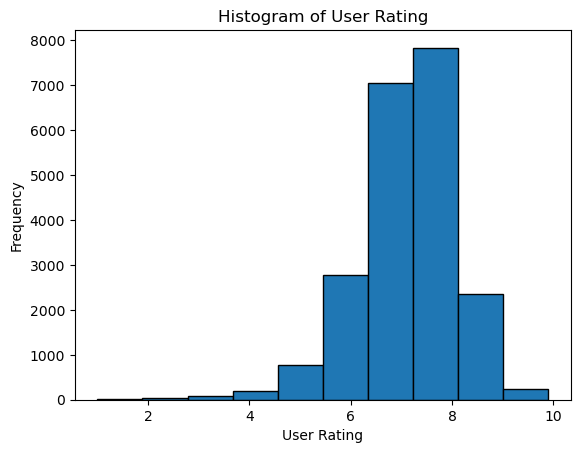

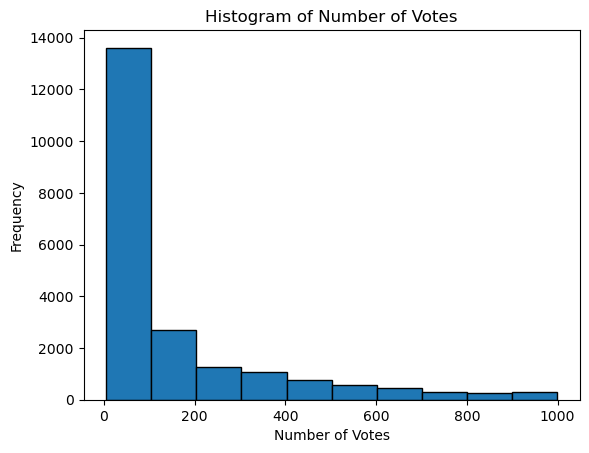

In [3]:
# Question 2
# For numeric variables, check any outliers and remove them or replace them with a certain value
plt.hist(df['User Rating'], edgecolor='black')
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.title('Histogram of User Rating')
plt.show()

plt.hist(df['Number of Votes'], edgecolor='black')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Votes')
plt.show()

In [4]:
# Question 3
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Perform ANOVA test for feature selection
x = df.loc[:, ['User Rating', 'Number of Votes']]
y = df.loc[:, 'Genre']

fs = SelectKBest(score_func=f_classif, k='all')
bestFeatures = fs.fit(x, y)
np.set_printoptions(suppress = True)

print("ANOVA F-Scores:", bestFeatures.scores_)
print("ANOVA P-Values:", bestFeatures.pvalues_)
print()

ANOVA F-Scores: [15.02977462 12.41240807]
ANOVA P-Values: [0. 0.]



In [5]:
# Question 3
chi = SelectKBest(score_func=chi2, k='all')
catFeatures = chi.fit(x, y)

print("CHI F-Scores:", catFeatures.scores_)
print("CHI P-Values:", catFeatures.pvalues_)
print()

# Dummy Variables
df['Genre'] = df['Genre'].str.split(', ')
dfDummies = df['Genre'].str.join('|').str.get_dummies()

# Every entry should have animation as a genre tag
dfDummies.drop('Animation', axis=1, inplace=True)

combined_df = pd.concat([df, dfDummies], axis=1)
combined_df.drop('Genre', axis=1, inplace=True)

CHI F-Scores: [   309.4999201  562948.50187612]
CHI P-Values: [0. 0.]



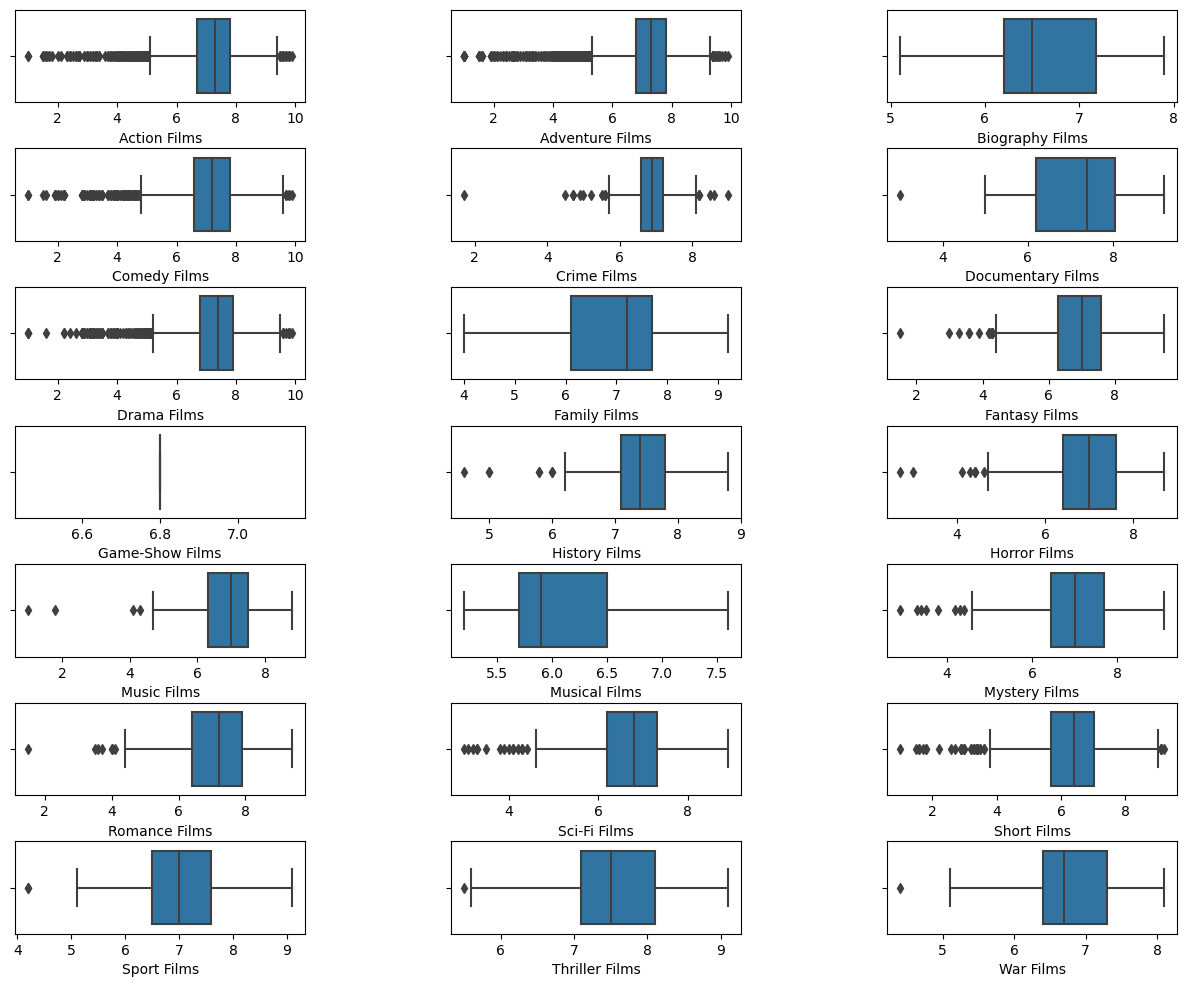

In [6]:
# Question 3
genre_columns = [col for col in combined_df if col not in ['User Rating', 'Number of Votes']]

subplots = len(genre_columns)
cols = 3
rows = (subplots + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15,12))
axes = axes.ravel()

# Scatterplots for User Rating
for i, genre in enumerate(genre_columns):
    filtered = combined_df[combined_df[genre] == 1]
    
    sns.boxplot(x=filtered['User Rating'], ax=axes[i])
    axes[i].set_xlabel(f"{genre} Films")

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

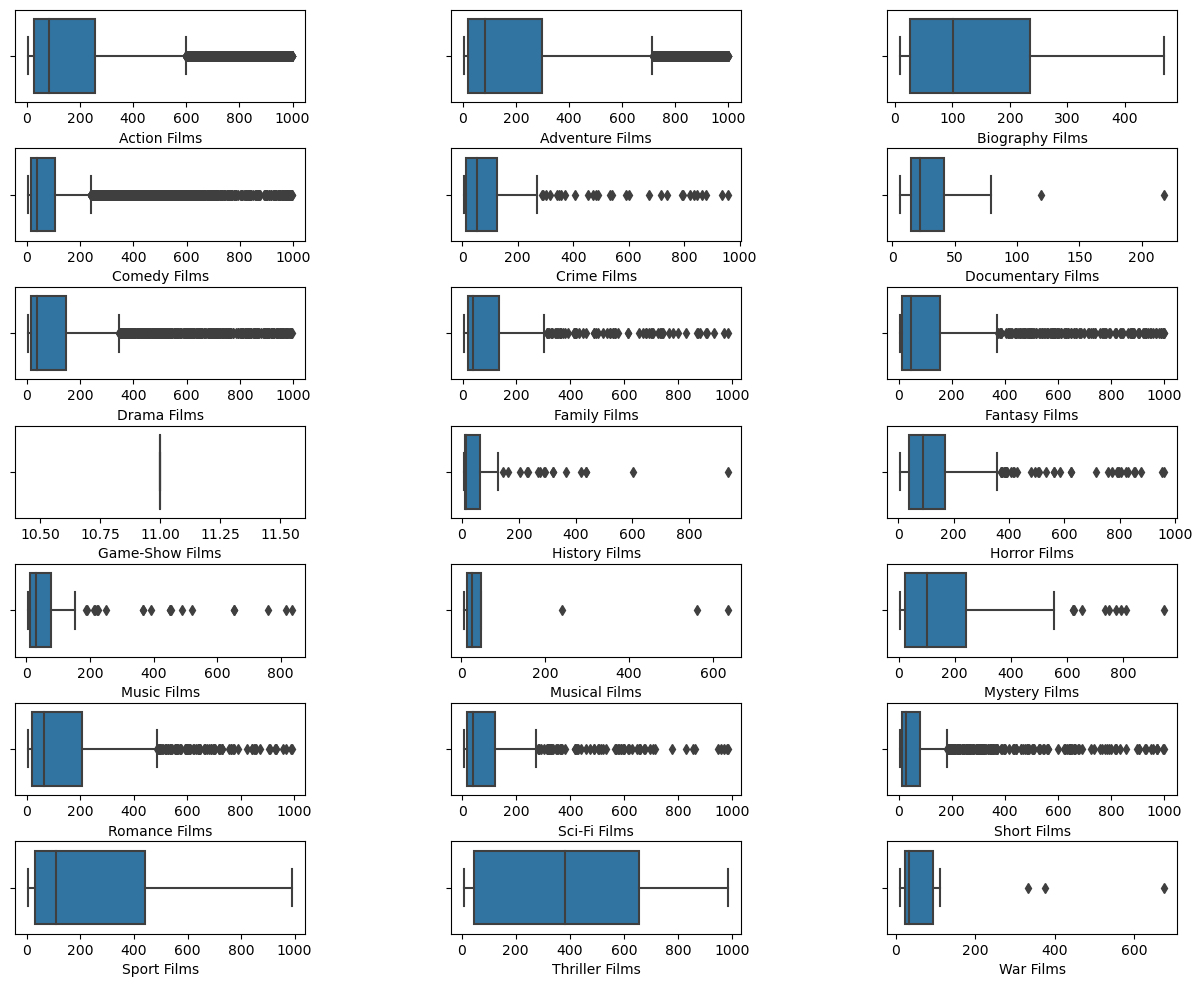

In [7]:
# Question 3
genre_columns = [col for col in combined_df if col not in ['User Rating', 'Number of Votes']]

subplots = len(genre_columns)
cols = 3
rows = (subplots + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15,12))
axes = axes.ravel()

# Scatterplots for Number of Votes
for i, genre in enumerate(genre_columns):
    filtered = combined_df[combined_df[genre] == 1]
    
    sns.boxplot(x=filtered['Number of Votes'], ax=axes[i])
    axes[i].set_xlabel(f"{genre} Films")

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [8]:
# Question 4
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import RandomOverSampler

for genre in genre_columns:
    x = combined_df.loc[:, ['User Rating', 'Number of Votes']]
    y = combined_df[genre]
    
    os = RandomOverSampler(sampling_strategy='minority')
    x, y = os.fit_resample(x, y)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    model = RandomForestRegressor(n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Genre: {genre}")
    print(f"MSE: {mse: .4f}")
    print(f"R^2: {r2:.4f}")
    print()

Genre: Action
MSE:  0.2227
R^2: 0.1093

Genre: Adventure
MSE:  0.2675
R^2: -0.0700

Genre: Biography
MSE:  0.0016
R^2: 0.9937

Genre: Comedy
MSE:  0.2014
R^2: 0.1944

Genre: Crime
MSE:  0.0298
R^2: 0.8809

Genre: Documentary
MSE:  0.0029
R^2: 0.9885

Genre: Drama
MSE:  0.1650
R^2: 0.3402

Genre: Family
MSE:  0.0433
R^2: 0.8269

Genre: Fantasy
MSE:  0.0840
R^2: 0.6642

Genre: Game-Show
MSE:  0.0002
R^2: 0.9991

Genre: History
MSE:  0.0149
R^2: 0.9404

Genre: Horror
MSE:  0.0201
R^2: 0.9197

Genre: Music
MSE:  0.0206
R^2: 0.9178

Genre: Musical
MSE:  0.0013
R^2: 0.9946

Genre: Mystery
MSE:  0.0150
R^2: 0.9399

Genre: Romance
MSE:  0.0522
R^2: 0.7910

Genre: Sci-Fi
MSE:  0.0547
R^2: 0.7814

Genre: Short
MSE:  0.0837
R^2: 0.6652

Genre: Sport
MSE:  0.0148
R^2: 0.9409

Genre: Thriller
MSE:  0.0058
R^2: 0.9769

Genre: War
MSE:  0.0018
R^2: 0.9927

